<a href="https://colab.research.google.com/github/McMafia/ADMMBO/blob/main/ADMMBO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from math import sin
from math import pi
from numpy import arange
from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal
from numpy.random import random
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot
import numpy as np

In [28]:
class problem:
  
  def __init__(self,K,dim,n,m,delta,rho,eps,M,y1,z1,num_constraint,alpha,beta,bounds,model_opt,model_feas,F,X,C,Z):
    self.ADMM_iter=K
    self.dim=dim
    self.n=n
    self.m=m
    self.delta=delta
    self.rho=rho
    self.eps=eps
    self.M=M
    self.y1=np.mean(y1,axis=0)
    self.z1=np.mean(z1,axis=0)
    self.num_constraint=num_constraint
    self.X=X
    self.beta=beta
    self.B=bounds
    self.U=[]
    self.F=F
    self.model_opt=model_opt
    self.model_feas=model_feas
    self.C=C
    self.Z=Z

  def obj_func(self,vec):
    self.vec=vec
    return -(np.cos((vec[0]-0.1)*vec[1]))**2-vec[0]*np.sin(3*vec[0]+vec[1])

  def constr_func(self,vec):
    t=np.arctan(vec[0]/(vec[1]+1E-9))
    return vec[0]*vec[0]+vec[1]*vec[1]-(2*np.cos(t)-0.5*np.cos(2*t)-0.25*np.cos(3*t)-0.125*np.cos(4*t))**2 - (2*np.sin(t))**2
  
  def OPT(self,alpha,y1,z1):
    self.alpha=alpha
    self.y1=np.mean(y1,axis=0)
    self.z1=np.mean(z1,axis=0)
    
    U=np.zeros(self.n)
    U=U.reshape((self.n,-1))
    for i in range(self.n):
      U[i]=self.F[i]+(self.rho/2)*(np.linalg.norm(self.X[i]-self.z1+self.y1/self.rho))**2

    for t in range(alpha):
      model_opt.fit(self.X,U)
      Xsamples=np.random.uniform(self.B[0][0],self.B[0][1],(200,self.dim))
      

      mu,std=self.surrogate_X(model_opt,Xsamples)
      mu=np.array(mu)
      std=np.array(std)
      
      best=min(U)
      
      l=np.empty((0,1),float)
      probs=np.empty((0,1),float)

  #doubt here    
      for i in range(200):
        l=np.vstack((l,(best-mu[i])/(std[i]+1E-9)))
        #probs = np.vstack((probs,norm.cdf((best-mu[i]) / (std[i]+1E-9))))
        probs=np.vstack((probs,std[i]*(l[i]*norm.cdf(l[i])+norm.pdf((l[i])))))

      ix=np.argmax(probs)
      self.X=np.vstack((self.X,Xsamples[ix]))
      self.F=np.vstack((self.F,self.obj_func(Xsamples[ix])))
      
      U=np.vstack((U,self.obj_func(Xsamples[ix])+self.rho/2*(np.linalg.norm(Xsamples[ix]-self.z1+self.y1/self.rho))**2))
     
      ##############

      self.n=self.n+1


    index=np.argmin(U)

    return self.X[index]

  def FEAS(self,ix,xmin,y1,z1):
    H=np.zeros((self.m[ix],1))
    H.reshape((self.m[ix],-1))
    self.y1=np.mean(y1,axis=0)
    self.z1=np.mean(z1,axis=0)
    
    for i in range(self.m[ix]):
      H[i]=5*int(self.C[ix][i]>0)+(self.rho/(2*self.M))*(np.linalg.norm(xmin-self.Z[ix][i]+self.y1/self.rho))**2
    
    hplus=min(H)
    #print(H)
    for t in range(self.beta[ix]):
      model_feas[ix].fit(self.Z[ix][0:self.m[ix]],self.C[ix][0:self.m[ix]])
      Zsamples=np.random.uniform(self.B[0][0],self.B[0][1],(100,self.dim))
      mu,std=self.surrogate_Z(model_feas[ix],Zsamples)
      
      theta=np.zeros(100)
      theta.reshape((100,-1))
      
      probs=np.zeros(100)
      
      for i in range(100):
        
        theta[i] = 1-norm.cdf(-mu[i]/std[i])
        
        if hplus - (self.rho/(2*self.M))*(np.linalg.norm(xmin-Zsamples[i]+self.y1/self.rho))**2 <= 0:
          probs[i]=0
        
        if hplus-(self.rho/(2*self.M))*(np.linalg.norm(xmin-Zsamples[i]+self.y1/self.rho))**2>0 and hplus-(self.rho/(2*self.M))*(np.linalg.norm(xmin-Zsamples[i]+self.y1/self.rho))**2<=1:
          probs[i]= (hplus-(self.rho/(2*self.M))*(np.linalg.norm(xmin-Zsamples[i]+self.y1/self.rho))**2)*(1-theta[i])
        
        if hplus-(self.rho/(2*self.M))*(np.linalg.norm(xmin-Zsamples[i]+self.y1/self.rho))**2>1:
          probs[i]= (hplus-(self.rho/(2*self.M))*(np.linalg.norm(xmin-Zsamples[i]+self.y1/self.rho))**2)*(1-theta[i])+theta[i]*(hplus-1-(self.rho/(2*self.M))*(np.linalg.norm(xmin-Zsamples[i]+self.y1/self.rho))**2)

      idx=np.argmax(probs)
      #print(theta)
      Zsamples=Zsamples.reshape(100,2)

      self.Z[ix][self.m[ix]]=Zsamples[idx]
      h=int(self.constr_func(Zsamples[idx]>0))+(self.rho/(2*self.M))*(np.linalg.norm(xmin-Zsamples[idx]+self.y1/self.rho))**2

      H=np.vstack((H,np.array([h])))
      self.C[ix][self.m[ix]]=self.constr_func(Zsamples[idx])

      self.m[ix]=self.m[ix]+1

    zmin=np.argmin(H)
      
    zmin=(self.Z[ix][zmin])
    
    return zmin  

  def surrogate_X(self,model, X):
	 
    # catch any warning generated when making a prediction
  	with catch_warnings():
		  # ignore generated warnings
	  	simplefilter("ignore")
	  	return model.predict(X, return_std=True)
    
  def surrogate_Z(self,model, Zsamples):
	 
    # catch any warning generated when making a prediction
  	with catch_warnings():
		  # ignore generated warnings
	  	simplefilter("ignore")
	  	return model.predict(Zsamples, return_std=True)
    
      

In [29]:
#initializing parameters
K=100
dim=2
n=4
m=np.array([4])
delta=0.5
rho=0.1
eps=0.01
M=40


N=1

bound=[(-2.25,2.25),(-2.25,2.25)]

#creating the random initial vectors for ADMM
y1=np.full((N,dim),0.0)
z1=np.full((N,dim),0.0)



#defining the model
model_opt = GaussianProcessRegressor()
model_feas=[GaussianProcessRegressor() for i in range(N)]



#budgets for each of the iterations
alpha=np.random.randint(2,5,K)
alpha[0]=20
beta=np.random.randint(2,5,N)
beta[0]=20

F=np.zeros(n)
F=F.reshape((n,-1))
X = np.zeros((n,dim))
C=np.zeros((N, np.max(m)+np.max(beta)*K))
Z = np.zeros((N, np.max(m)+K*np.max(beta), dim))

prob=problem(K,dim,n,m,delta,rho,eps,M,y1,z1,N,alpha,beta,bound,model_opt,model_feas,F,X,C,Z)

for i in range(prob.num_constraint):
  for j in range(prob.m[i]):
    prob.Z[i][j]=np.random.uniform(-2.25,2.5,size=(dim))
    prob.C[i][j]=prob.constr_func(Z[i][j])
answers=np.zeros((K+1,dim))
for i in range(n):
   prob.X[i]=(np.random.uniform(-2.25,2.5,prob.dim))

   prob.F[i]=prob.obj_func(prob.X[i])

In [30]:
def ADMMBO():
 
  S=False
  k=0
  zstar=np.zeros((N,dim))
  r=np.full((N,2),1e9)
  s=np.full((N,2),1e9)
  mini=1e9+0.1
  xstar=np.array([0.0,0.0])
  while k<prob.ADMM_iter and S==False:
    print(k)
    xstar=prob.OPT(alpha[k],y1,z1)
    zprev=np.mean(z1,axis=0)
    for i in range(prob.num_constraint):
      
      
      z1[i]=prob.FEAS(i,xstar,y1,z1)
      y1[i]=y1[i]+prob.rho*(xstar-z1[i])
      
      r[i]=xstar-z1[i]
      s[i]=-prob.rho*(z1[i]-zprev)
      
      zprev=z1[i]
                      
    
    if np.linalg.norm(r) <=prob.eps and np.linalg.norm(s) <=prob.eps:
      S=True
    k=k+1   
    if(np.linalg.norm(r)>=10*np.linalg.norm(s)):
      prob.rho=2*prob.rho

    if(np.linalg.norm(s)>=np.linalg.norm(r)*10):
      prob.rho=prob.rho/2
    
    answers[k]=xstar
    print(xstar,np.linalg.norm(r),np.linalg.norm(s))
    if(prob.constr_func(xstar)<=0):
      print('yesssssssss')
    
    
      

    if S==True:
      print(xstar,"answer is here!!!!!")    
    
      

In [ ]:
ADMMBO()

In [8]:

import matplotlib.pyplot as plt
import numpy as np



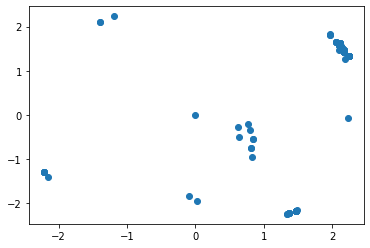

In [32]:
plt.scatter(answers[:,0],answers[:,1])

In [36]:
prob.obj_func([1.94,1.26])

-1.8495999578371507

In [ ]:
prob.X.shape

(322, 2)